# CROWD-LABELING FOR CONTINUOUS-VALUED ANNOTATIONS

The code in this notebook is a reimplementation of the work described in **"Modeling annotator behaviors for crowd labeling" [1]** and **"Actively estimating crowd annotation consensus" [2]**.
The original code for the former work was implemented in MATLAB and the latter, a more comprehensive one, was implemented in C++. However, the C++ code is part of a larger project that I am unable to share.

I reimplemented the main part of the code in Python 3.7.3 for reaching a wider range of researchers from various disciplines. The code is unevitably slower than the original C++ implementation. It currently runs on a single core; parallelizing the parameter and consensus update codes should decrease the inference time. Note that the precision of the results may slightly vary due to implementation and hardware differences.

You are encouraged to play around with the code and apply it to your own data for continuous-valued consensus estimation in crowd labeling.

If you use this work, please do not forget to cite the related papers given below. The detailed descriptions of the models and their derivations can be found in my PhD thesis [3].

 &ndash; Yunus Emre Kara
## References
1. Kara, Y. E.; Genc, G.; Aran, O.; & Akarun, L. (2015). "_Modeling annotator behaviors for crowd labeling_", Neurocomputing, 160, 141-156.
1. Kara, Y. E.; Genc, G.; Aran, O.; & Akarun, L. (2018). "_Actively Estimating Crowd Annotation Consensus_", Journal of Artificial Intelligence Research, 61, 363-405.
1. Kara, Y. E. (2018). "_Crowd Labeling For Continuous Valued Annotations_", PhD Thesis, Bogazici University, Istanbul, Turkey.

## Datasets
- **Age Annotations Dataset**: http://yekara.com/age_annotations/
- **Head Pose Annotations Dataset**: http://yekara.com/headpose_annotations/


***
## 1. HELPER CODE
### 1.1. Dataset configurations

In [1]:
dataset_headpose_tilt = {
    'filename_annotations': 'headpose_annotations.csv',
    'filename_groundtruth': 'headpose_groundtruth.csv',
    'value_function': lambda x: float(x['Tilt'])-4,
    'value_function_groundtruth': lambda x: float(x['Tilt']),
    'ann_space_to_gt_space': lambda x: x*30,
    'hyperparameters': {'alpha_l': 1.2, 'beta_l': 0.9, 'beta_w': 4e4, 'mu_b': 0, 'S_b': 0.05**2}
}

dataset_headpose_pan = {
    'filename_annotations': 'headpose_annotations.csv',
    'filename_groundtruth': 'headpose_groundtruth.csv',
    'value_function': lambda x: float(x['Pan'])-4,
    'value_function_groundtruth': lambda x: float(x['Pan']),
    'ann_space_to_gt_space': lambda x: x*30,
    'hyperparameters': {'alpha_l': 1.2, 'beta_l': 0.9, 'beta_w': 4e4, 'mu_b': 0, 'S_b': 0.05**2}
}

dataset_age = {
    'filename_annotations': 'age_annotations.csv',
    'filename_groundtruth': 'age_groundtruth.csv',
    'value_function': lambda x: float(x['Age'])-4,
    'value_function_groundtruth': lambda x: float(x['Age']),
    'ann_space_to_gt_space': lambda x: (x+3)/6*69,
    'hyperparameters': {'alpha_l': 1.2, 'beta_l': 0.9, 'beta_w': 4e1, 'mu_b': 0, 'S_b': 0.05**2}
}

### 1.2. Type Definitions

In [2]:
from abc import ABC, abstractmethod

from typing import Callable, NamedTuple, List, Optional, Tuple, NewType, Dict, DefaultDict, Set

class Limit(NamedTuple):
    lower: Optional[float] = None
    upper: Optional[float] = None
        
    def check(self, value):
        return not (self.lower and value < self.lower) and not (self.upper and value > self.upper)
    
    def clamp(self, value):
        return self.lower if value < self.lower else self.upper if value > self.upper else value

SampleId = NewType('SampleId', str)
AnnotatorId = NewType('AnnotatorId', str)
AnnotationId = NewType('AnnotationId', str)
AnnotationValue = NewType('AnnotationValue', float)

class Annotation(NamedTuple):
    sample_id: SampleId
    annotator_id: AnnotatorId
    value: AnnotationValue

### 1.3. AnnotationProvider class
Base class for annotation providers.

In [3]:
        
class AnnotationProvider(ABC):
    @abstractmethod
    def is_available(self) -> bool:
        pass
    
    @abstractmethod
    def available_annotators_for_sample(self, sample_id: SampleId) -> List[AnnotatorId]:
        pass
    
    @abstractmethod
    def samples_with_available_annotators(self) -> List[SampleId]:
        pass
    
    @abstractmethod
    def draw(self, sample_id: Optional[SampleId] = None, annotator_id: Optional[AnnotatorId] = None, **kwargs) -> Annotation:
        pass
 

### 1.4. AnnotationPool class
This class is derived from the AnnotationProvider class. It is used for reading precollected annotation values from "csv" files.

In [4]:
from typing import Tuple
from collections import defaultdict
import random

class AnnotationPool(AnnotationProvider):
    def __init__(self,
                 filename_annotations: str,
                 value_function: Callable[[Dict[str,float]],float] = None,
                 sample_column: str = 'SampleID',
                 annotator_column: str = 'AnnotatorID',
                 **kwargs):
        from csv import DictReader
        
        self.filename_annotations = filename_annotations
        self.value_function = value_function
        self.sample_column = sample_column
        self.annotator_column = annotator_column

        self.annotations_data = dict()
        self.annotation_ids_for_sample = defaultdict(set)
        self.annotation_ids_of_annotator = defaultdict(set)
        
        with open(filename_annotations) as csv_file:
            annotations_reader = DictReader(csv_file, delimiter=';')
            for annotation in annotations_reader:
                sample_id = annotation[self.sample_column]
                annotator_id = annotation[self.annotator_column]
                annotation_id = 'ann{2}_Of{0}_From{1}'.format(sample_id, annotator_id, len(self.annotations_data))
                self.annotations_data[annotation_id] = annotation
                self.annotation_ids_for_sample[sample_id].add(annotation_id)
                self.annotation_ids_of_annotator[annotator_id].add(annotation_id)

    def is_available(self) -> bool:
        return bool(self.annotations_data)
    
    def available_annotators_for_sample(self, sample_id: SampleId) -> List[AnnotatorId]:
        return [self.annotations_data[annotation_id][self.annotator_column] for annotation_id in self.annotation_ids_for_sample[sample_id]]
          
    def samples_with_available_annotators(self) -> List[SampleId]:
        return list(self.annotation_ids_for_sample.keys())

    def draw(self, sample_id: Optional[SampleId] = None, 
             annotator_id: Optional[AnnotatorId] = None, 
             paired_random: bool = True, 
             annotation_id: Optional[AnnotationId] = None, 
             pop: bool = True) -> Annotation:
        if annotation_id:
            annotation = self.annotations_data[annotation_id]
            sample_id = annotation[self.sample_column]
            annotator_id = annotation[self.annotator_column]
        else:
            if annotator_id:
                if not sample_id:
                    raise ValueError('sample_id is not set')
            else:
                if sample_id:
                    annotator_id = random.choice(self.available_annotators_for_sample(sample_id))
                else:
                    if paired_random:
                        annotation = self.annotations_data[random.choice(list(self.annotations_data.keys()))]
                        sample_id, annotator_id = annotation[self.sample_column], annotation[self.annotator_column]
                    else:
                        sample_id = random.choice(self.samples_with_available_annotators())
                        annotator_id = random.choice(self.available_annotators_for_sample(sample_id))
            annotation_id = next(k for k in self.annotation_ids_for_sample[sample_id] if self.annotations_data[k][self.annotator_column] == annotator_id)
        
        if pop:
            annotation = self.annotations_data.pop(annotation_id)
    
            self.annotation_ids_for_sample[sample_id].remove(annotation_id)
            if not self.annotation_ids_for_sample[sample_id]:
                del self.annotation_ids_for_sample[sample_id]
                
            self.annotation_ids_of_annotator[annotator_id].remove(annotation_id)
            if not self.annotation_ids_of_annotator[annotator_id]:
                del self.annotation_ids_of_annotator[annotator_id]
        else:
            annotation = self.annotations_data[annotation_id]

        return Annotation(sample_id, annotator_id, self.value_function(annotation))

### 1.5. GroundTruthProvider class
This class is for retrieving the ground truth values used for estimating the model error.

In [5]:
class GroundTruthProvider:
    def __init__(self,filename_groundtruth: str,
                 sample_column: str = 'SampleID',
                 value_function_groundtruth: Callable[[Dict[str,float]],float] = None,
                 ann_space_to_gt_space = None,
                 **kwargs):
        from csv import DictReader
        self.filename_groundtruth = filename_groundtruth

        self.sample_column = sample_column
        self.value_function = value_function_groundtruth
        self.ann_space_to_gt_space = ann_space_to_gt_space

        with open(filename_groundtruth) as csv_file:
            annotations_reader = DictReader(csv_file, delimiter=';')
            self.groundtruth_data = {row[sample_column]: row for row in annotations_reader}
                
    def groundtruth(self, sample_id: SampleId):
        if not self.groundtruth_data:
            raise ValueError('Ground truth values are not set')
        return self.value_function(self.groundtruth_data[sample_id])
    
    def error(self, sample_id: SampleId, consensus: float):
        return abs(self.ann_space_to_gt_space(consensus)-self.groundtruth(sample_id))
    

### 1.6. AnnotationDataset class
This is the main class that the models use for storing annotation information.

In [6]:
class AnnotationDataset:
    annotations: Dict[AnnotationId,Annotation]
    annotation_ids_for_sample: DefaultDict[SampleId,Set[AnnotationId]]
    annotation_ids_of_annotator: DefaultDict[AnnotatorId,Set[AnnotationId]]

    def __init__(self, annotation_pool: Optional[AnnotationPool] = None):
        self.annotations: Dict[AnnotationId,Annotation] = dict()
        self.annotation_ids_for_sample: DefaultDict[SampleId,Set[AnnotationId]] = defaultdict(set)
        self.annotation_ids_of_annotator: DefaultDict[AnnotatorId,Set[AnnotationId]] = defaultdict(set)
        if annotation_pool:
            while annotation_pool.is_available():
                self.add(annotation_pool.draw())
            
    def add(self, annotation: Annotation):
        annotation_id = 'ann{2}_Of{0}_From{1}'.format(annotation.sample_id, annotation.annotator_id, len(self.annotations))
        self.annotations[annotation_id] = annotation
        self.annotation_ids_for_sample[annotation.sample_id].add(annotation_id)
        self.annotation_ids_of_annotator[annotation.annotator_id].add(annotation_id)

    def samples(self) -> List[SampleId]:
        return self.annotation_ids_for_sample.keys()
        
    def annotators(self) -> List[AnnotatorId]:
        return self.annotation_ids_of_annotator.keys()
    
    def sample_count(self) -> int:
        return len(self.annotation_ids_for_sample)
        
    def annotator_count(self) -> int:
        return len(self.annotation_ids_of_annotator)
    
    def annotation_count(self) -> int:
        return len(self.annotations)

### 1.7. Helper classes and functions

In [7]:
from timeit import default_timer as timer
import math

class Timer:    
    def __enter__(self):
        self.start = timer()
        return self

    def __exit__(self, *args):
        self.end = timer()
        self.interval = self.end - self.start
        
class FitInfo(NamedTuple):
    annotation_count: int
    sample_count: int
    annotator_count: int
    iteration_count: int
    log_posterior: float
    new_annotation: Annotation
    selected_sample_score: float
    selected_annotator_score: float
    annotation_fit_error_mae: float
    annotation_fit_error_mse: float
    groundtruth_fit_error_mae: float
    groundtruth_fit_error_mse: float

    def print(self, fields, print_names = True):
        d = self._asdict()
        if print_names:
            print({FitInfo.title(field):d[field] for field in fields})  
        else:
            print([d[field] for field in fields])
    
    @staticmethod
    def init(model, fit_result, groundtruth_provider = None, new_annotation = None, selected_sample_score = None, selected_annotator_score = None):
        return FitInfo(**{'annotation_count': model.dataset.annotation_count(),
            'sample_count': model.dataset.sample_count(),
            'annotator_count': model.dataset.annotator_count(),
            'iteration_count': fit_result[0] if fit_result else None,
            'log_posterior': fit_result[1] if fit_result else None,
            'new_annotation': new_annotation,
            'selected_sample_score': selected_sample_score,
            'selected_annotator_score': selected_annotator_score,
            'annotation_fit_error_mae': model.fit_error(1),
            'annotation_fit_error_mse': model.fit_error(2),
            'groundtruth_fit_error_mae': model.groundtruth_error(groundtruth_provider, 1) if groundtruth_provider else None,
            'groundtruth_fit_error_mse': model.groundtruth_error(groundtruth_provider, 2) if groundtruth_provider else None})

    @staticmethod
    def title(field):
        return field.replace('_',' ').title().replace('Mae','(MAE)').replace('Mse','(MSE)')
        
    @staticmethod
    def plot_list(fit_info_list, fields, figsize=(7,5), title='', ncols = 3):
        from matplotlib import pyplot as plt
        %matplotlib inline

        if len(fields) < ncols:
            ncols = len(fields)
        nrows = 1+(len(fields)-1)//ncols
        
        figsize = (figsize[0] * ncols, figsize[1] * nrows)
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = figsize, squeeze=False)
        plt.subplots_adjust(hspace=0.3)
        
        def get_axis(i):
            r, c = i//ncols, i%ncols
            return ax[r, c]

        for i, field in enumerate(fields):
            f = get_axis(i)
            f.plot(*zip(*[(fit_info.annotation_count,fit_info._asdict()[field]) for fit_info in fit_info_list]))
            f.set_title(FitInfo.title(field))
            f.set_xlabel('Annotation count')
            f.grid(True)
            
        for i in range(len(fields), nrows*ncols):
            get_axis(i).axis('off')
            
        plt.show()


def loggammapdf(x, a, b):
    return a*math.log(b) - math.lgamma(a) + (a - 1)*math.log(x) - b*x

def lognormpdf(x, mu, S):
    return -0.5*math.log(2*math.pi*S) - 0.5*(x-mu)*(x-mu)/S;

def cubic_root(a,b,c,d):
    # based on https://github.com/shril/CubicEquationSolver/blob/master/CubicEquationSolver.py
    if a == 0 and b == 0: # Linear
        return [-d/c]

    elif a == 0: # Quadratic
        delta = c**2-4*b*d
        if delta >= 0:
            D = math.sqrt(delta)
            x1 = (-c + D) / (2.0 * b)
            x2 = (-c - D) / (2.0 * b)
        else:
            D = math.sqrt(-delta)
            x1 = (-c + D * 1j) / (2.0 * b)
            x2 = (-c - D * 1j) / (2.0 * b)
        return [x1,x2]
    else:

        q = (3*a*c - b**2) / (9 * a**2)
        r = (9*a*b*c - 27*a**2*d - 2*b**3) / (54*a**3)
        
        delta = q**3 + r**2
        
        if q == 0 and r == 0 and delta == 0:            # All 3 Roots are Real and Equal
            if (d / a) >= 0:
                x = (d / (1.0 * a)) ** (1 / 3.0) * -1
            else:
                x = (-d / (1.0 * a)) ** (1 / 3.0)
            return [x]
        elif delta <= 0:                                # All 3 roots are Real
            rho = math.sqrt(r**2 - delta)
            rho_cr = rho**(1./3.)
            theta = math.acos(r / rho)
            M = math.cos(theta / 3.0)
            N = math.sqrt(3) * math.sin(theta / 3.0)
            P = (b / (3.0 * a)) * -1
    
            x1 = 2 * rho_cr * math.cos(theta / 3.0) - (b / (3.0 * a))
            x2 = -rho_cr * (M + N) + P
            x3 = -rho_cr * (M - N) + P
    
            return [x1, x2, x3]
    
        elif delta > 0:                                 # One Real Root and two Complex Roots
            R = r + math.sqrt(delta)
            if R >= 0:
                S = R ** (1 / 3.0)
            else:
                S = (-R) ** (1 / 3.0) * -1
            T = r - math.sqrt(delta)
            if T >= 0:
                U = (T ** (1 / 3.0))
            else:
                U = ((-T) ** (1 / 3.0)) * -1
    
            x1 = (S + U) - (b / (3.0 * a))
            x2 = -(S + U) / 2 - (b / (3.0 * a)) + (S - U) * math.sqrt(3) * 0.5j
            x3 = -(S + U) / 2 - (b / (3.0 * a)) - (S - U) * math.sqrt(3) * 0.5j
            return [x1, x2, x3]
    

***
## 2. MODEL DEFINITIONS
The codes for M-AH, M-SH, M-ABS, and M-CBS models defined in the paper "Modeling annotator behaviors for crowd labeling" [1].
### 2.1. Base AnnotationModel class

In [8]:
from types import SimpleNamespace

class AnnotationModel(ABC):
    class Annotator:
        def __init__(self, params):
            pass
                
        def predict(self, x):
            return x
                    
        def precision(self):
            return 0

    def __init__(self, dataset, hyperparameters = {}, x_range = Limit(-3,3)):
        self.dataset = dataset
        self.x_range = x_range
        self.hyperparameters = SimpleNamespace(**hyperparameters)
        self.x, self.annotator = {}, {}

        for sample_id in self.dataset.annotation_ids_for_sample.keys():
            self.init_sample(sample_id)
            
        for annotator_id in self.dataset.annotation_ids_of_annotator.keys():
            self.init_annotator(annotator_id)
            
    def add_annotation(self, annotation):       
        if annotation.annotator_id not in self.dataset.annotators():
            self.init_annotator(annotation.annotator_id)
        if annotation.sample_id not in self.dataset.samples():
            self.init_sample(annotation.sample_id)
        self.dataset.add(annotation)
    
    @staticmethod
    @abstractmethod
    def name(self):
        pass
    
    @abstractmethod
    def update_consensus(self):
        pass
    
    @abstractmethod
    def update_parameters(self):
        pass
    
    @abstractmethod
    def annotator_score(self, annotator_id: AnnotatorId) -> float:
        return 0
    
    @abstractmethod    
    def sample_score(self, sample_id: SampleId) -> float:
        return 0
   
    @abstractmethod
    def log_prior(self) -> float:
        return 0
    
    def log_likelihood(self) -> float:
        for annotator_id in self.dataset.annotators():
            annotator = self.annotator[annotator_id]
            annotations = self.dataset.annotation_ids_of_annotator[annotator_id]
            precision = annotator.precision()
            prob = len(annotations)*0.5*math.log(annotator.precision()/(2*math.pi));
            for annotation_id in annotations:
                annotation = self.dataset.annotations[annotation_id]
                prob -= 0.5*precision*(annotation.value - annotator.predict(self.x[annotation.sample_id]))**2;
#             prob = 0;
#             for annotation_id in annotations:
#                 annotation = self.dataset.annotations[annotation_id]
#                 prob += lognormpdf(annotation.value, annotator.predict(self.x[annotation.sample_id]), 1/precision);
        return prob
    
    def log_posterior(self):
        return self.log_prior() + self.log_likelihood()
    
    def init_annotator(self, annotator_id):
        self.annotator[annotator_id] = self.Annotator(self.hyperparameters)

    def init_sample(self, sample_id):
        self.x[sample_id] = random.uniform(self.x_range.lower, self.x_range.upper)
    
    def predict(self, sample_id, annotator_id):
        return self.annotator[annotator_id].predict(self.x[sample_id])
                
    def dominance_suppression_factor(self, annotator_id: AnnotatorId, phi: float):
        return len(self.dataset.annotation_ids_of_annotator[annotator_id])**(-phi*self.dataset.annotator_count()/self.dataset.annotation_count())

    def fit_error(self, power = 1):
        err = sum(abs(self.predict(annotation.sample_id, annotation.annotator_id) - annotation.value)**power for annotation in self.dataset.annotations.values())
        err /= len(self.dataset.annotations)
        return err**(1/power)
    
    def groundtruth_error(self, groundtruth_provider, power:int = 1):
        return (sum(groundtruth_provider.error(sample_id,consensus)**power for sample_id, consensus in self.x.items())/len(self.x))**(1/power)
    
    def fit(self, max_iterations = 1000, eps = 1e-7):
        LP = float('-inf');

        for it in range(max_iterations):
            self.update_consensus()
            self.update_parameters()

            prevLP = LP;
            LP = self.log_posterior()
            diff = LP - prevLP
            if diff >= 0 and diff < eps:
                break  
        return it, LP


### 2.2. M-AH: Adversary Handling Model
The model is defined by $\displaystyle\prod\limits_{k=1}^{K}
\mathcal{N}\left(y_k;a_{j_k} x_{i_k},\frac{1}{\lambda_j}\right) \displaystyle\prod\limits_{j=1}^{R}\mathcal{G}\left(\lambda_j; \alpha_\lambda, \beta_\lambda\right)$ where
- $y_k$ is the value of annotation $k$.
- $K$ and $R$ are the annotation and the annotator counts.
- $i_k$ and $j_k$ denote the sample and the annotator of the annotation $k$, respectively. 
- $x_{i_k}$ is the consensus value for the sample ${i_k}$.
- $\lambda_j$ and $a_j$ are the precision and the adverseness parameters of the annotator $j$, respectively.

In [9]:
class Model_AH(AnnotationModel):
    class Annotator(AnnotationModel.Annotator):
        a: int
        l: float
        def __init__(self, params):
            self.a = 1
            self.l = random.gammavariate(params.alpha_l, 1/params.beta_l)
                
        def predict(self, x):
            return self.a * x
                        
        def precision(self):
            return self.l
        
    def __init__(self, dataset, hyperparameters = {'alpha_l': 1.2, 'beta_l': 0.9}, x_range = Limit(-3,3)):
        super().__init__(dataset, hyperparameters, x_range)
        
    @staticmethod
    def name(self):
        return "M-AH"
    
    def log_prior(self):
        prob = 0
        for annotator_id in self.dataset.annotators():
            annotator = self.annotator[annotator_id]
            prob += loggammapdf(annotator.l, self.hyperparameters.alpha_l, self.hyperparameters.beta_l);
        return prob

    def annotator_score(self, annotator_id: AnnotatorId):
        annotator = self.annotator[annotator_id]
        d = min(self.x_range.upper, max(self.x_range.lower, annotator.a * annotator.predict(self.x_range.lower)))
        e = max(self.x_range.lower, min(self.x_range.upper, annotator.a * annotator.predict(self.x_range.upper)))
        return math.sqrt(annotator.l/math.pi)*(e-d)
        
    def sample_score(self, sample_id: SampleId):
        return sum(self.annotator[annotator_id].l for annotation_id in self.dataset.annotation_ids_for_sample[sample_id])
        
    def update_consensus(self):
        for sample_id, annotation_ids  in self.dataset.annotation_ids_for_sample.items():
            numerator = 0
            denominator = 0
            for annotation_id in annotation_ids:
                annotation = self.dataset.annotations[annotation_id]
                annotator = self.annotator[annotation.annotator_id]
                numerator += annotator.l*annotator.a*annotation.value
                denominator += annotator.l
            self.x[sample_id] = numerator/denominator
            
    def update_parameters(self):
        annotator_count = len(self.dataset.annotation_ids_of_annotator)
        nAdverseAnnotators = 0
        for annotator_id, annotation_ids in self.dataset.annotation_ids_of_annotator.items():
            N = len(annotation_ids)
            annotator = self.annotator[annotator_id]
         
            yy_sum = yx_sum = xx_sum = 0
            for annotation_id in annotation_ids:
                annotation = self.dataset.annotations[annotation_id]
                y = annotation.value
                x = self.x[annotation.sample_id]
                yy_sum += y*y
                yx_sum += y*x
                xx_sum += x*x

            # a update
            annotator.a = 1 if yx_sum > 0 else -1
            if annotator.a == -1:
                nAdverseAnnotators += 1
                
            # l update
            annotator.l = (N+2*(self.hyperparameters.alpha_l-1)) / (2*self.hyperparameters.beta_l
                  + yy_sum
                  + xx_sum
                  - 2*annotator.a*yx_sum)

        if nAdverseAnnotators > annotator_count/2:
            for annotator_id in self.annotator:
                annotator = self.annotator[annotator_id]
                annotator.a = -annotator.a
            for s in self.x:  
                self.x[s] = -self.x[s]

### 2.3. M-SH: Scale Handling Model
The model is defined by $\displaystyle\prod\limits_{k=1}^{K}
\mathcal{N}\left(y_k;a_{j_k} w_{j_k} x_{i_k},\frac{1}{\lambda_j}\right) \displaystyle\prod\limits_{j=1}^{R}\mathcal{G}\left(\lambda_j; \alpha_\lambda, \beta_\lambda\right)\mathcal{G}\left(w_j; \beta_w+1, \beta_w\right)$ where
- $y_k$ is the value of annotation $k$.
- $K$ and $R$ are the annotation and the annotator counts.
- $i_k$ and $j_k$ denote the sample and the annotator of the annotation $k$, respectively. 
- $x_i$ is the consensus value for the sample $i$.
- $\lambda_j$, $a_j$, and $w_j$ are the precision, the adverseness, and the opinion scale parameters of the annotator $j$, respectively.

In [10]:
class Model_SH(AnnotationModel):
    class Annotator(AnnotationModel.Annotator):
        a: int
        l: float
        w: float
        def __init__(self, params):
            self.a = 1
            self.l = random.gammavariate(params.alpha_l, 1/params.beta_l)
            self.w = random.gammavariate(params.beta_w+1, 1/params.beta_w)
                
        def predict(self, x):
            return self.a * self.w * x
                        
        def precision(self):
            return self.l
        
    def __init__(self, dataset, hyperparameters = {'alpha_l': 1.2, 'beta_l': 0.9, 'beta_w': 4}, x_range = Limit(-3,3)):
        super().__init__(dataset, hyperparameters, x_range)
            
    @staticmethod
    def name(self):
        return "M-SH"
    
    def log_prior(self):
        prob = 0
        for annotator_id in self.dataset.annotators():
            annotator = self.annotator[annotator_id]
            prob += loggammapdf(annotator.l, self.hyperparameters.alpha_l, self.hyperparameters.beta_l);
            prob += loggammapdf(annotator.w, self.hyperparameters.beta_w+1, 1/self.hyperparameters.beta_w);
        return prob
    
    def annotator_score(self, annotator_id: AnnotatorId):
        annotator = self.annotator[annotator_id]
        d = min(self.x_range.upper, max(self.x_range.lower, annotator.a * annotator.predict(self.x_range.lower)))
        e = max(self.x_range.lower, min(self.x_range.upper, annotator.a * annotator.predict(self.x_range.upper)))
        return math.sqrt(annotator.l*(annotator.w**2+1)/(2*math.pi))*(e-d)/annotator.w
        
    def sample_score(self, sample_id: SampleId):
        return sum(self.annotator[annotator_id].w**2 * self.annotator[annotator_id].l for annotation_id in self.dataset.annotation_ids_for_sample[sample_id])

    def update_consensus(self):
        for sample_id, annotation_ids  in self.dataset.annotation_ids_for_sample.items():
            numerator = 0
            denominator = 0
            for annotation_id in annotation_ids:
                annotation = self.dataset.annotations[annotation_id]
                annotator = self.annotator[annotation.annotator_id]
                numerator += annotator.l*annotator.w*annotator.a*annotation.value
                denominator += annotator.l*annotator.w*annotator.w
            self.x[sample_id] = self.x_range.clamp(numerator/denominator)
            
    def update_parameters(self):
        annotator_count = len(self.dataset.annotation_ids_of_annotator)
        nAdverseAnnotators = 0
        for annotator_id, annotation_ids in self.dataset.annotation_ids_of_annotator.items():
            N = len(annotation_ids)
            annotator = self.annotator[annotator_id]
         
            y_sum = x_sum = yy_sum = yx_sum = xx_sum = 0
            for annotation_id in annotation_ids:
                annotation = self.dataset.annotations[annotation_id]
                y = annotation.value
                x = self.x[annotation.sample_id]
                x_sum += x
                y_sum += y
                yy_sum += y*y
                yx_sum += y*x
                xx_sum += x*x
                
            if xx_sum != 0:
                # w update
                w_tmp = (-self.hyperparameters.beta_w/annotator.l + annotator.a*yx_sum)/(2*xx_sum)
                w_tmp += math.sqrt(w_tmp*w_tmp + self.hyperparameters.beta_w/(annotator.l*xx_sum))
                annotator.w = w_tmp
            
            # a update
            annotator.a = 1 if yx_sum > 0 else -1
            if annotator.a == -1:
                nAdverseAnnotators += 1
                
            # l update
            annotator.l = (N+2*(self.hyperparameters.alpha_l-1)) / (2*self.hyperparameters.beta_l
                  + yy_sum
                  + xx_sum*annotator.w**2
                  - 2*annotator.a*annotator.w*yx_sum)

        if nAdverseAnnotators > annotator_count/2:
            for annotator_id in self.annotator:
                annotator = self.annotator[annotator_id]
                annotator.a = -annotator.a
            for s in self.x:  
                self.x[s] = -self.x[s]

### 2.4. M-ABS: Annotation Bias Sensitive Model
The model is defined by $\displaystyle\prod\limits_{k=1}^{K}
\mathcal{N}\left(y_k;a_{j_k} (w_{j_k} x_{i_k}+b_{j_k}),\frac{1}{\lambda_j}\right) \displaystyle\prod\limits_{j=1}^{R}\mathcal{G}\left(\lambda_j; \alpha_\lambda, \beta_\lambda\right)\mathcal{G}\left(w_j; \beta_w+1, \beta_w\right)\mathcal{N}\left(b_j; \mu_B, s_B^2\right)$ where
- $y_k$ is the value of annotation $k$.
- $K$ and $R$ are the annotation and the annotator counts.
- $i_k$ and $j_k$ denote the sample and the annotator of the annotation $k$, respectively. 
- $x_i$ is the consensus value for the sample $i$.
- $\lambda_j$, $a_j$, $w_j$, and $b_j$ are the precision, the adverseness, the opinion scale, and the annotator bias parameters of the annotator $j$, respectively.

In [11]:
class Model_ABS(AnnotationModel):
    class Annotator(AnnotationModel.Annotator):
        a: int
        l: float
        w: float
        b: float
        def __init__(self, params):
            self.a = 1
            self.l = random.gammavariate(params.alpha_l, 1/params.beta_l)
            self.w = random.gammavariate(params.beta_w+1, 1/params.beta_w)
            self.b = random.gauss(params.mu_b,params.S_b**0.5)
                
        def predict(self, x):
            return self.a * (self.w * x + self.b)
                
        def precision(self):
            return self.l
        
    def __init__(self, dataset, hyperparameters = {'alpha_l': 1.2, 'beta_l': 0.9, 'beta_w': 4, 'mu_b': 0, 'S_b': 0.05**2}, x_range = Limit(-3,3)):
        super().__init__(dataset, hyperparameters, x_range)
            
    @staticmethod
    def name(self):
        return "M-ABS"
    
    def log_prior(self):
        prob = 0
        for annotator_id in self.dataset.annotators():
            annotator = self.annotator[annotator_id]
            prob += loggammapdf(annotator.l, self.hyperparameters.alpha_l, self.hyperparameters.beta_l);
            prob += loggammapdf(annotator.w, self.hyperparameters.beta_w+1, 1/self.hyperparameters.beta_w);
            prob += lognormpdf(annotator.b, self.hyperparameters.mu_b, self.hyperparameters.S_b);
        return prob
    
    def annotator_score(self, annotator_id: AnnotatorId):
        annotator = self.annotator[annotator_id]
        d = min(self.x_range.upper, max(self.x_range.lower, annotator.a * annotator.predict(self.x_range.lower)))
        e = max(self.x_range.lower, min(self.x_range.upper, annotator.a * annotator.predict(self.x_range.upper)))
        return math.sqrt(annotator.l*(annotator.w**2+1)/(2*math.pi))*(e-d)/annotator.w
        
    def sample_score(self, sample_id: SampleId):
        return sum(self.annotator[annotator_id].w**2 * self.annotator[annotator_id].l for annotation_id in self.dataset.annotation_ids_for_sample[sample_id])

    def update_consensus(self):
        for sample_id, annotation_ids  in self.dataset.annotation_ids_for_sample.items():
            numerator = 0
            denominator = 0
            for annotation_id in annotation_ids:
                annotation = self.dataset.annotations[annotation_id]
                annotator = self.annotator[annotation.annotator_id]
                numerator += annotator.l*annotator.w*(annotator.a*annotation.value-annotator.b)
                denominator += annotator.l*annotator.w*annotator.w
            self.x[sample_id] = self.x_range.clamp(numerator/denominator)
            
    def update_parameters(self):
        annotator_count = len(self.dataset.annotation_ids_of_annotator)
        nAdverseAnnotators = 0
        for annotator_id, annotation_ids in self.dataset.annotation_ids_of_annotator.items():
            N = len(annotation_ids)
            annotator = self.annotator[annotator_id]
         
            y_sum = x_sum = yy_sum = yx_sum = xx_sum = 0
            for annotation_id in annotation_ids:
                annotation = self.dataset.annotations[annotation_id]
                y = annotation.value
                x = self.x[annotation.sample_id]
                x_sum += x
                y_sum += y
                yy_sum += y*y
                yx_sum += y*x
                xx_sum += x*x
            
            # b update
            b_numerator = annotator.a*y_sum - annotator.w *x_sum + self.hyperparameters.mu_b/(self.hyperparameters.S_b*annotator.l)
            b_denominator = N + 1/(self.hyperparameters.S_b*annotator.l)
            annotator.b = b_numerator/b_denominator
            
            # w update
            w_tmp = (-self.hyperparameters.beta_w/annotator.l + annotator.a*yx_sum - annotator.b*x_sum)/(2*xx_sum)
            w_tmp += math.sqrt(w_tmp*w_tmp + self.hyperparameters.beta_w/(annotator.l*xx_sum))
            annotator.w = w_tmp
            
            # a update
            annotator.a = 1 if (yx_sum*annotator.w+y_sum*annotator.b) > 0 else -1
            if annotator.a == -1:
                nAdverseAnnotators += 1
                
            # l update
            annotator.l = (N+2*(self.hyperparameters.alpha_l-1)) / (2*self.hyperparameters.beta_l
                  + N*annotator.b**2 
                  + yy_sum
                  + xx_sum*annotator.w**2
                  + 2*annotator.b*annotator.w* x_sum
                  - 2*annotator.a*(yx_sum*annotator.w + y_sum*annotator.b))

        if nAdverseAnnotators > annotator_count/2:
            for annotator_id in self.annotator:
                annotator = self.annotator[annotator_id]
                annotator.a = -annotator.a
                annotator.b = -annotator.b
            for s in self.x:  
                self.x[s] = -self.x[s]


### 2.5. M-CBS: Consensus Bias Sensitive Model
The model is defined by $\displaystyle\prod\limits_{k=1}^{K}
\mathcal{N}\left(y_k;a_{j_k} w_{j_k} (x_{i_k}+b_{j_k}),\frac{w_{j_k}^2}{\lambda_j}\right) \displaystyle\prod\limits_{j=1}^{R}\mathcal{G}\left(\lambda_j; \alpha_\lambda, \beta_\lambda\right)\mathcal{G}\left(w_j; \beta_w+1, \beta_w\right)\mathcal{N}\left(b_j; \mu_B, s_B^2\right)$ where
- $y_k$ is the value of annotation $k$.
- $K$ and $R$ are the annotation and the annotator counts.
- $i_k$ and $j_k$ denote the sample and the annotator of the annotation $k$, respectively. 
- $x_i$ is the consensus value for the sample $i$.
- $\lambda_j$, $a_j$, $w_j$, and $b_j$ are the precision, the adverseness, the opinion scale, and the annotator bias parameters of the annotator $j$, respectively.

In [12]:
class Model_CBS(AnnotationModel):
    class Annotator(AnnotationModel.Annotator):
        a: int
        l: float
        w: float
        b: float
        def __init__(self, params):
            self.a = 1
            self.l = random.gammavariate(params.alpha_l, 1/params.beta_l)
            self.w = random.gammavariate(params.beta_w+1, 1/params.beta_w)
            self.b = random.gauss(params.mu_b,params.S_b**0.5)
                
        def predict(self, x):
            return self.a * self.w * (x + self.b)
        
        def precision(self):
            return self.l/self.w**2
        
    def __init__(self, dataset, hyperparameters = {'alpha_l': 1.2, 'beta_l': 0.9, 'beta_w': 4e4, 'mu_b': 0, 'S_b': 0.05**2}, x_range = Limit(-3,3)):
        super().__init__(dataset, hyperparameters, x_range)
    
    @staticmethod
    def name(self):
        return "M-CBS"
    
    def log_prior(self):
        prob = 0
        for annotator_id in self.dataset.annotators():
            annotator = self.annotator[annotator_id]
            prob += loggammapdf(annotator.l, self.hyperparameters.alpha_l, self.hyperparameters.beta_l);
            prob += loggammapdf(annotator.w, self.hyperparameters.beta_w+1, 1/self.hyperparameters.beta_w);
            prob += lognormpdf(annotator.b, self.hyperparameters.mu_b, self.hyperparameters.S_b);
        return prob

    def annotator_score(self, annotator_id: AnnotatorId):
        annotator = self.annotator[annotator_id]
        d = min(self.x_range.upper, max(self.x_range.lower, annotator.a * annotator.predict(self.x_range.lower)))
        e = max(self.x_range.lower, min(self.x_range.upper, annotator.a * annotator.predict(self.x_range.upper)))
        return math.sqrt(annotator.l*(annotator.w**2+1)/(2*math.pi))*(e-d) / (annotator.w**2)

    def sample_score(self, sample_id: SampleId):
        return sum(self.annotator[self.dataset.annotations[annotation_id].annotator_id].l for annotation_id in self.dataset.annotation_ids_for_sample[sample_id])

    def update_consensus(self):       
        for sample_id, annotation_ids in self.dataset.annotation_ids_for_sample.items():
            numerator = 0
            denominator = 0
            for annotation_id in annotation_ids:
                annotation = self.dataset.annotations[annotation_id]
                annotator = self.annotator[annotation.annotator_id]
                numerator += annotator.l*(annotator.a/annotator.w*annotation.value-annotator.b)
                denominator += annotator.l
            self.x[sample_id] = self.x_range.clamp(numerator/denominator)

    def update_parameters(self):
        annotator_count = len(self.dataset.annotation_ids_of_annotator)
        nAdverseAnnotators = 0
        for annotator_id, annotation_ids in self.dataset.annotation_ids_of_annotator.items():
            N = len(annotation_ids)
            annotator = self.annotator[annotator_id]
         
            y_sum = x_sum = yy_sum = yx_sum = xx_sum = 0
            for annotation_id in annotation_ids:
                annotation = self.dataset.annotations[annotation_id]
                y = annotation.value
                x = self.x[annotation.sample_id]
                x_sum += x
                y_sum += y
                yy_sum += y*y
                yx_sum += y*x
                xx_sum += x*x
            
            # b update
            b_numerator = annotator.a/annotator.w * y_sum - x_sum + self.hyperparameters.mu_b/(self.hyperparameters.S_b*annotator.l)
            b_denominator = N + 1/(self.hyperparameters.S_b*annotator.l)
            annotator.b = b_numerator/b_denominator
            
            # w update
            V0 = -self.hyperparameters.beta_w
            V1 = self.hyperparameters.beta_w-N
            V2 = -annotator.l*annotator.a*(yx_sum+y_sum*annotator.b)
            V3 = annotator.l*yy_sum
            w_inv = list(map(lambda x: x.real, filter(lambda x: x.real>0 and x.imag==0, cubic_root(V3,V2,V1,V0))))
            #            w_inv = list(map(lambda x: np.real(x), filter(lambda x: np.isreal(x) and x>0, np.roots([V3,V2,V1,V0]))))
            if len(w_inv) != 1:
                print(w_inv)
                raise ValueError('')
            annotator.w = 1/w_inv[0]

            # a update
            annotator.a = 1 if (yx_sum+y_sum*annotator.b) > 0 else -1
            if annotator.a == -1:
                nAdverseAnnotators += 1
                
            # l update
            annotator.l = (N+2*(self.hyperparameters.alpha_l-1)) / (2*self.hyperparameters.beta_l
                  + N*annotator.b**2 
                  + yy_sum/annotator.w**2
                  + xx_sum
                  + 2*annotator.b * x_sum
                  - 2*annotator.a/annotator.w * (yx_sum + y_sum*annotator.b))

        if nAdverseAnnotators > annotator_count/2:
            for annotator_id in self.annotator:
                annotator = self.annotator[annotator_id]
                annotator.a = -annotator.a
                annotator.b = -annotator.b
            for s in self.x:  
                self.x[s] = -self.x[s]


***
## 3. MODEL FITTING
### 3.1. Passive crowd-labeling
Below is a sample code for applying passive crowd-labeling model M-CBS defined in the paper "Modeling annotator behaviors for crowd labeling" [1] to the whole Head Pose Pan dataset.

In [13]:
%%time
dataset_conf = dataset_headpose_pan
groundtruth_provider = GroundTruthProvider(**dataset_conf)
dataset = AnnotationDataset(AnnotationPool(**dataset_conf)) 

model = Model_CBS(dataset, hyperparameters = dataset_conf['hyperparameters'])
fit_result = model.fit()

fit_info = FitInfo.init(model, fit_result, groundtruth_provider)
fit_info.print(['annotation_count','sample_count','annotator_count','new_annotation',
            'selected_sample_score','iteration_count','log_posterior',
            'annotation_fit_error_mae','groundtruth_fit_error_mae','groundtruth_fit_error_mse'], True)

{'Annotation Count': 5399, 'Sample Count': 555, 'Annotator Count': 189, 'New Annotation': None, 'Selected Sample Score': None, 'Iteration Count': 27, 'Log Posterior': -152666085.96817395, 'Annotation Fit Error (MAE)': 0.3119845609238426, 'Groundtruth Fit Error (MAE)': 6.72522172914437, 'Groundtruth Fit Error (MSE)': 10.211221300750898}
Wall time: 933 ms


### 3.2. Active crowd-labeling
Below is a sample code for applying active crowd-labeling method O-CBS+ defined in the paper "Actively Estimating Crowd Annotation Consensus" [2] to the whole Age Annotations dataset.
The code below has a few minimal differences than the O-CBS+ method described in the paper, but it should give similar results.

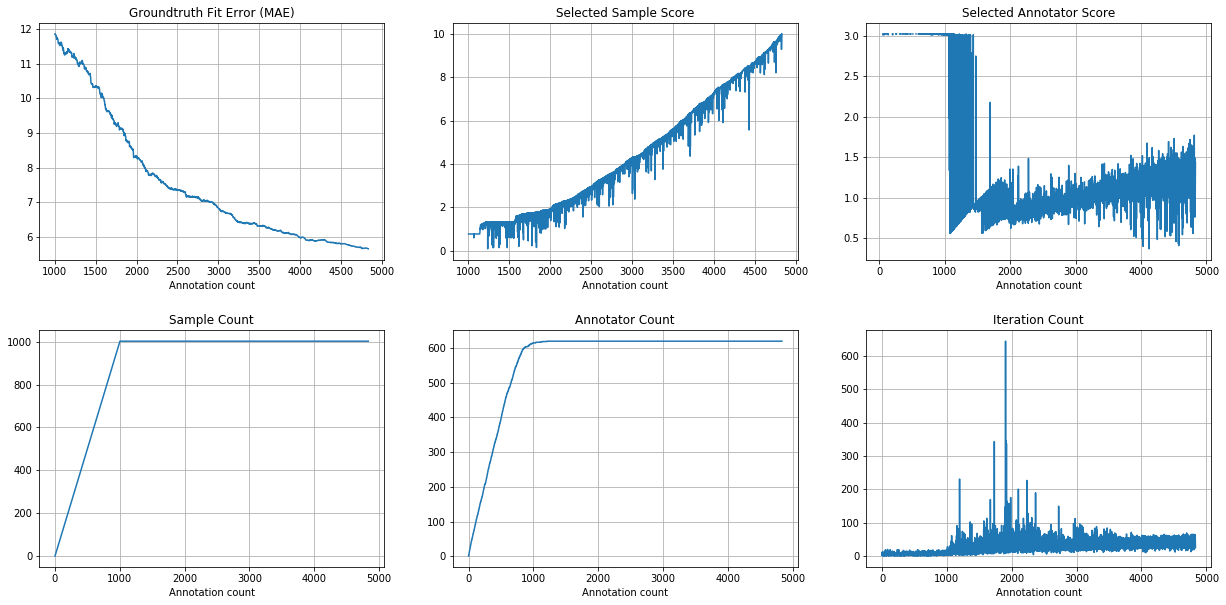

All samples reached the predefined score threshold 10
{'Annotation Count': 4833, 'Sample Count': 1002, 'Annotator Count': 619, 'New Annotation': Annotation(sample_id='061A19.JPG', annotator_id='21839425', value=-1.0), 'Selected Sample Score': 9.998689727722175, 'Iteration Count': 26, 'Log Posterior': -163095.48624928395, 'Annotation Fit Error (MAE)': 0.5309181900439023, 'Groundtruth Fit Error (MAE)': 5.658926524840982, 'Groundtruth Fit Error (MSE)': 7.926610958499008}


In [14]:
# init dataset configuration
dataset_conf = dataset_age
annotation_provider = AnnotationPool(**dataset_conf)
groundtruth_provider = GroundTruthProvider(**dataset_conf)
dataset = AnnotationDataset()

# init model
model = Model_CBS(dataset, hyperparameters = dataset_conf['hyperparameters'])

# Model fitting parameters
fit_max_iterations = 1000
fit_eps = 1e-5

# Dominance Suppression Coefficient \phi defined in Section 4.2 of [2]
dominance_suppression_coefficient_phi = 5

# Exploration Parameter \epsilon defined in Section 5 of [2]
exploration_threshold_epsilon = 0.75

# Sample Scoring Threshold \tau defined in Section 5.4 of [2]
sample_score_based_stopping_threshold_tau: Optional[float] = 10 #Setting to None will disable early stopping

# Fitting statistics
fit_info_list: List[FitInfo] = []
time_sample_selection = []
time_annotator_selection = []
time_model_fitting = []

report_frequency = 100
early_stop = False

def report():
    from IPython.display import clear_output
    clear_output(wait=True)
    FitInfo.plot_list(fit_info_list, ['groundtruth_fit_error_mae', 'selected_sample_score', 'selected_annotator_score', 'sample_count', 'annotator_count', 'iteration_count'])
    if early_stop:
        print('All samples reached the predefined score threshold', sample_score_based_stopping_threshold_tau)
    fit_info_list[-1].print(['annotation_count','sample_count','annotator_count','new_annotation',
        'selected_sample_score','iteration_count','log_posterior',
        'annotation_fit_error_mae','groundtruth_fit_error_mae','groundtruth_fit_error_mse'])

while annotation_provider.is_available():
    # sample selection
    with Timer() as t:
        samples_with_available_annotators = annotation_provider.samples_with_available_annotators()
        samples_without_annotation = list(samples_with_available_annotators-model.dataset.samples())

        if samples_without_annotation:
            sample_id = random.choice(samples_without_annotation)
            selected_sample_score = None
        else:
            sample_scores = {sample_id: model.sample_score(sample_id) for sample_id in samples_with_available_annotators}
            sample_id = min(sample_scores, key=sample_scores.get)
            selected_sample_score = sample_scores[sample_id]
            if sample_score_based_stopping_threshold_tau and selected_sample_score > sample_score_based_stopping_threshold_tau:
                early_stop = True
                break
                
    time_sample_selection.append(t.interval)
    
    # annotator selection
    with Timer() as t:
        available_annotators = annotation_provider.available_annotators_for_sample(sample_id)
        explorable_annotators = list(available_annotators-model.dataset.annotators())
        all_annotators_are_new = len(available_annotators)==len(explorable_annotators)

        if all_annotators_are_new or (explorable_annotators and random.random() < exploration_threshold_epsilon):
            annotator_id = random.choice(explorable_annotators)
            selected_annotator_score = None
        else:
            exploitableAnnotators = set(available_annotators).intersection(model.dataset.annotators())
            annotator_scores = {annotator_id: model.annotator_score(annotator_id)*model.dominance_suppression_factor(annotator_id, dominance_suppression_coefficient_phi) for annotator_id in exploitableAnnotators}
            annotator_id = max(annotator_scores, key=annotator_scores.get)
            selected_annotator_score = annotator_scores[annotator_id]
    time_annotator_selection.append(t.interval)

    # annotation acquisition
    annotation = annotation_provider.draw(sample_id=sample_id, annotator_id=annotator_id)
    model.add_annotation(annotation)

    # reinit annotator
    model.init_annotator(annotation.annotator_id)
    
    # model fitting
    with Timer() as t:
        fit_result = model.fit(fit_max_iterations, fit_eps)
    time_model_fitting.append(t.interval)
    
    # result tracking
    calculate_gt_error = not samples_without_annotation # calculate ground truth error only if all samples have at least one annotation
    fit_info = FitInfo.init(model, fit_result, groundtruth_provider if calculate_gt_error else None, annotation, selected_sample_score, selected_annotator_score)
    fit_info_list.append(fit_info)

    if model.dataset.annotation_count() % report_frequency == 0:
        report()
report()